In [50]:
from pprint import pprint
from pathlib import Path
import numpy as np
import cv2
import yaml
import torch
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import tensorflow.compat.v1 as tf
import tensorflow as tf
assert tf.__version__ < '2', 'Requires TF 1.x'

detection_thresh = 0.005
nms_radius = 5

## Convert the TensorFlow weights into the PyTorch model.

In [44]:
import superpoint_pytorch
sp_th = superpoint_pytorch.SuperPoint(detection_threshold=detection_thresh, nms_radius=nms_radius).eval()
print('Config:', sp_th.conf)

# Download the TF weights to this directory
dir_ckpt_tf = Path('/home/student/ColonSuperPoint/ColonExperiments/experiments/saved_models/sp_v6')
path_ckpt_tf = dir_ckpt_tf / 'model.ckpt-300000'

reader = tf.train.NewCheckpointReader(str(path_ckpt_tf))
name2shape = reader.get_variable_to_shape_map()
keys = sorted(k for k in name2shape if not 'Adam' in k)
keys = [k for k in keys if not any(s in k for s in ['beta1_power', 'beta2_power', 'global_step'])]

tf_state_dict = {}
for k in keys:
    k2 = k.replace('superpoint/', '').replace('vgg', 'backbone')
    k2 = k2.replace('gamma', 'weight').replace('beta', 'bias').replace('kernel', 'weight')
    k2 = k2.replace('moving_', 'running_').replace('variance', 'var')

    prefix, block, *remain = k2.split('/')
    if prefix in ('descriptor', 'detector'):
        idx = str(int(block.replace('conv', ''))-1)
        k2 = (prefix, idx, *remain)
    else:
        i, j = block.replace('conv', '').split('_')
        k2 = (prefix, str(int(i)-1), str(int(j)-1), *remain)

    k2 = '.'.join(k2)
    assert k2 in sp_th.state_dict(), (k2, k)

    val = reader.get_tensor(k)
    if 'conv/kernel' in k:
        val = val.transpose(3,2,0,1)  # or probably not 3,2,1,0
    expected_shape = sp_th.state_dict()[k2].shape
    assert val.shape == expected_shape, (val.shape, expected_shape)
    tf_state_dict[k2] = torch.Tensor(val)
    
path_ckpt_th = 'weights/superpoint_v6_from_tf.pth'
torch.save(tf_state_dict, path_ckpt_th)
sp_th.load_state_dict(tf_state_dict)

Config: namespace(channels=[64, 64, 128, 128, 256], descriptor_dim=256, detection_threshold=0.005, max_num_keypoints=None, nms_radius=5, remove_borders=4)


<All keys matched successfully>

## Load an image to test the results.

  0%|          | 0.00/341k [00:00<?, ?B/s]

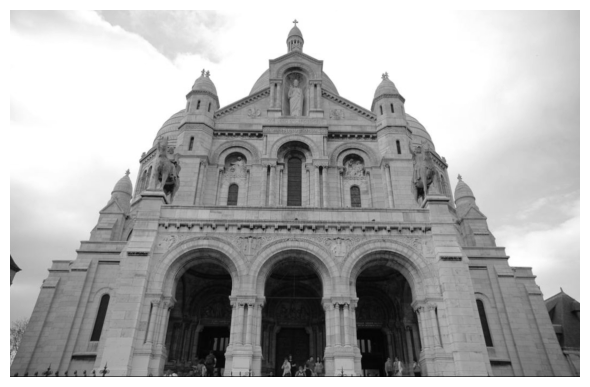

In [38]:
image_url = 'https://raw.githubusercontent.com/cvg/Hierarchical-Localization/master/datasets/sacre_coeur/mapping/03903474_1471484089.jpg'
image_path = 'image_sacre_coeur.jpg'
torch.hub.download_url_to_file(image_url, image_path)
from notebooks.utils import plot_imgs

image = cv2.imread(image_path).mean(-1) / 255
image = np.pad(image, [(0, int(np.ceil(s/8))*8 - s) for s in image.shape[:2]])
plot_imgs([image], cmap='gray')

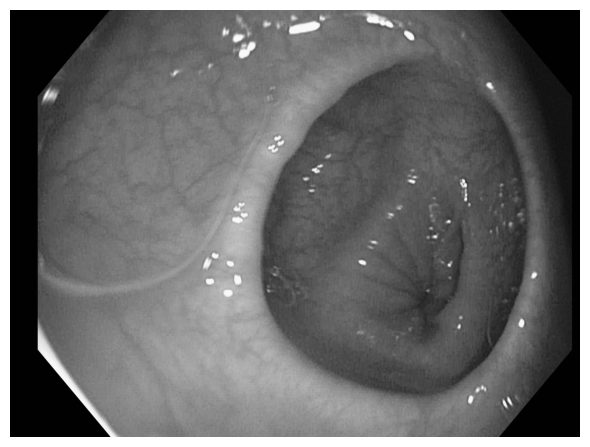

In [45]:
from notebooks.utils import plot_imgs

image_path = "/home/student/ColonSuperPoint/ColonExperiments/datasets/dataset_001_002/images_subsampled/seq_001_out2144.png"

image = cv2.imread(image_path).mean(-1) / 255
image = np.pad(image, [(0, int(np.ceil(s/8))*8 - s) for s in image.shape[:2]])
plot_imgs([image], cmap='gray')

## Run the inference with the TensorFlow model

{'batch_size': 3,
 'data_format': 'channels_last',
 'detection_threshold': 0.005,
 'eval_batch_size': 3,
 'lambda_d': 800,
 'lambda_loss': 1,
 'learning_rate': 0.0001,
 'name': 'super_point',
 'negative_margin': 0.2,
 'nms': 8,
 'positive_margin': 1,
 'top_k': 0}


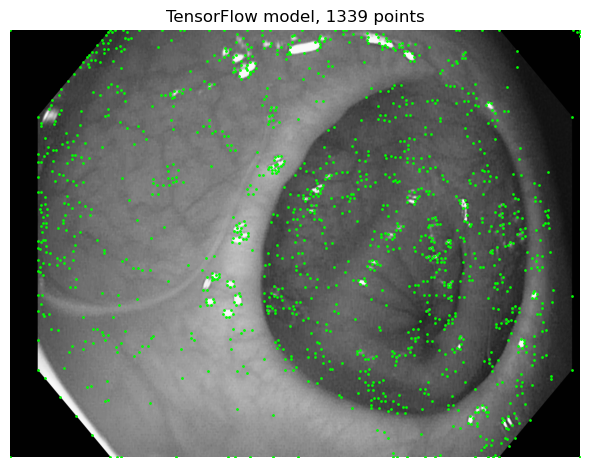

In [46]:
with open(dir_ckpt_tf / 'config.yml', 'r') as f:
    config_tf = yaml.load(f, Loader=yaml.Loader)
config_tf['model'].update({
    'data_format': 'channels_last',
    'top_k': 0,
    'detection_threshold': detection_thresh,
    'nms': (nms_radius - 1) * 2,  # seems equivalent
})
pprint(config_tf['model'])

tf.logging.set_verbosity(tf.logging.ERROR)
from superpoint.models import get_model
SuperPointTF = get_model(config_tf['model']['name'])
sp_tf = SuperPointTF(**config_tf['model'], n_gpus=0, data_shape={'image': [None, None, None, 1]})
sp_tf.load(str(dir_ckpt_tf))

pred_tf = sp_tf.predict({'image': image[:,:,None]}, keys='*')
points_tf = np.stack(np.where(pred_tf['pred']), -1)[:,::-1]
plot_imgs([image], cmap='gray', titles=[f'TensorFlow model, {len(points_tf)} points'])
plt.scatter(*points_tf.T, lw=0, s=4, c='lime');

## Run the inference with the PyTorch model

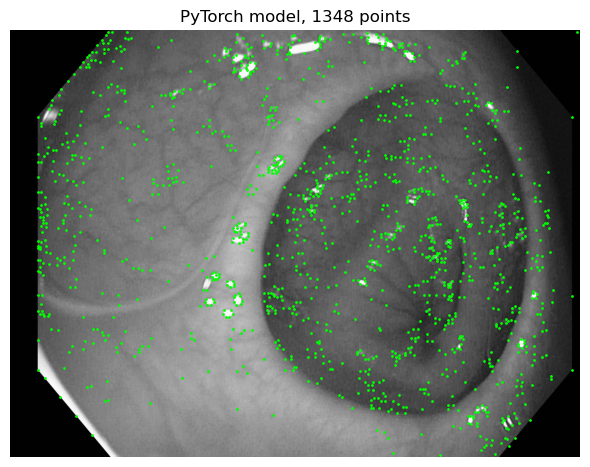

In [47]:
with torch.no_grad():
    pred_th = sp_th({'image': torch.from_numpy(image[None,None]).float()})
points_th = pred_th['keypoints'][0]
plot_imgs([image], cmap='gray', titles=[f'PyTorch model, {len(points_th)} points'])
plt.scatter(*points_th.T, lw=0, s=4, c='lime');

### Small differences are due to different NMS implementations.

## Compare the dense outputs

In [42]:
image_tensor = torch.from_numpy(image[None,None]).float()
with torch.no_grad():
    logits_dense = sp_th.detector(sp_th.backbone(image_tensor))
    desc_dense = sp_th.descriptor(sp_th.backbone(image_tensor))
logits_dense = logits_dense.squeeze(0).permute(1,2,0).numpy()
desc_dense = desc_dense.squeeze(0).permute(1,2,0).numpy()

diff = np.abs(logits_dense - pred_tf['logits'])
print('Diff logits:', diff.max(), diff.mean(), np.median(diff), 'max/mean/median')

diff = np.abs(desc_dense - pred_tf['descriptors_raw'])
print('Diff descriptors:', diff.max(), diff.mean(), np.median(diff), 'max/mean/median')

Diff logits: 0.0020751953 2.7481915e-06 2.026558e-06 max/mean/median
Diff descriptors: 0.0010261536 1.548424e-07 9.313226e-08 max/mean/median


## Compare to the official MagicLeap model

  0%|          | 0.00/7.95k [00:00<?, ?B/s]

  0%|          | 0.00/4.96M [00:00<?, ?B/s]

Loaded SuperPoint model


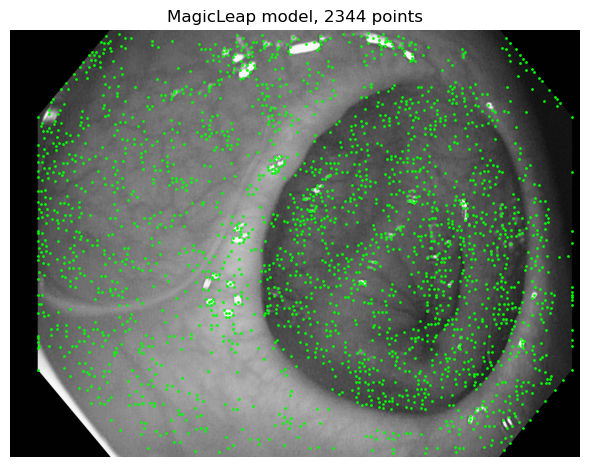

In [ ]:
url_def = 'https://raw.githubusercontent.com/magicleap/SuperGluePretrainedNetwork/master/models/superpoint.py'
url_ckpt_ml = 'https://github.com/magicleap/SuperGluePretrainedNetwork/raw/master/models/weights/superpoint_v1.pth'
path_ckpt_ml = 'weights/superpoint_v1_ml.pth'

torch.hub.download_url_to_file(url_def, 'superpoint_ml.py')
torch.hub.download_url_to_file(url_ckpt_ml, path_ckpt_ml)

from superpoint_ml import SuperPoint as SuperPointML
detection_thresh_ml = detection_thresh / 10  # heuristic
sp_ml = SuperPointML(dict(keypoint_threshold=detection_thresh_ml, nms_radius=nms_radius)).eval()
ckpt_ml = torch.load(path_ckpt_ml, map_location='cpu')
sp_ml.load_state_dict(ckpt_ml)

pred_ml = sp_ml({'image': torch.from_numpy(image[None,None]).float()})
points_ml = pred_ml['keypoints'][0]
plot_imgs([image], cmap='gray', titles=[f'MagicLeap model, {len(points_ml)} points'])
plt.scatter(*points_ml.T, lw=0, s=4, c='lime');

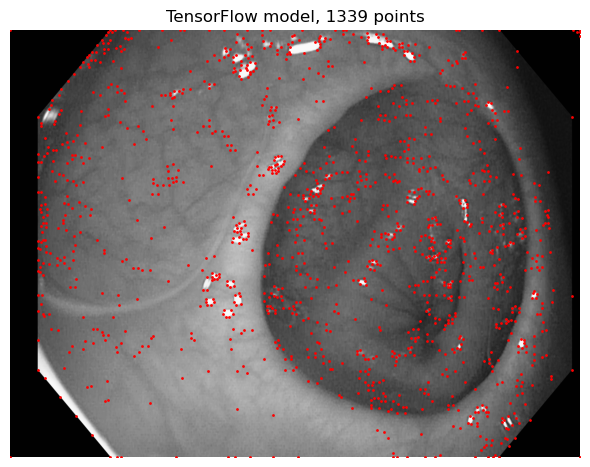

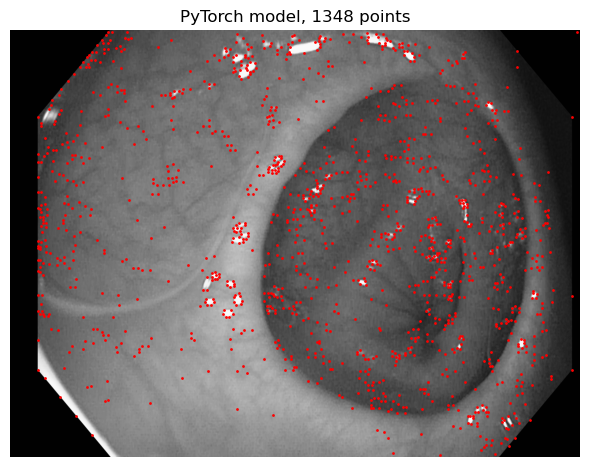

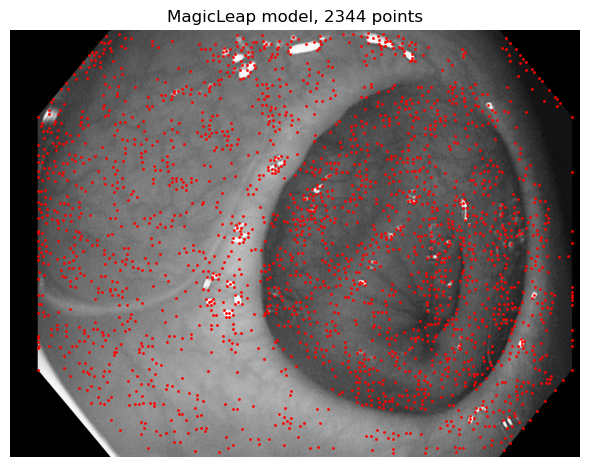

In [52]:
plot_imgs([image], cmap='gray', titles=[f'TensorFlow model, {len(points_tf)} points'])
plt.scatter(*points_tf.T, lw=0, s=4, c='red');

plot_imgs([image], cmap='gray', titles=[f'PyTorch model, {len(points_th)} points'])
plt.scatter(*points_th.T, lw=0, s=4, c='red');

plot_imgs([image], cmap='gray', titles=[f'MagicLeap model, {len(points_ml)} points'])
plt.scatter(*points_ml.T, lw=0, s=4, c='red');

## Test the batched inference

  0%|          | 0.00/447k [00:00<?, ?B/s]

  0%|          | 0.00/444k [00:00<?, ?B/s]

  0%|          | 0.00/349k [00:00<?, ?B/s]

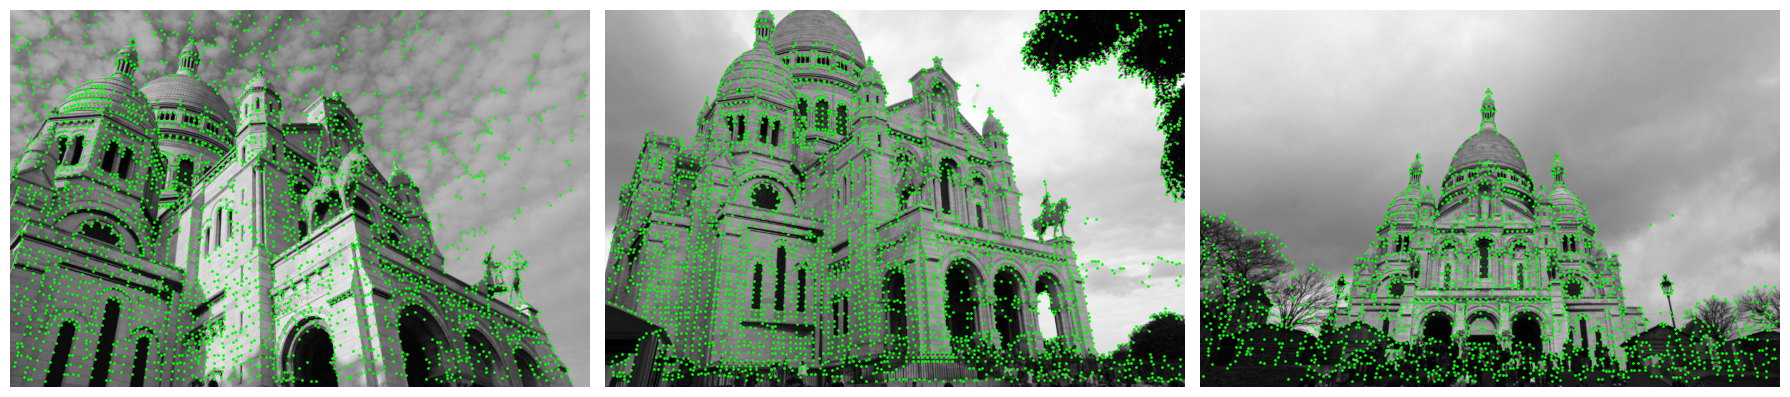

In [17]:
base_url = 'https://raw.githubusercontent.com/cvg/Hierarchical-Localization/master/datasets/sacre_coeur/mapping/'
names = ['32809961_8274055477.jpg', '10265353_3838484249.jpg', '44120379_8371960244.jpg']
images = []
for name in names:
    torch.hub.download_url_to_file(base_url + name, name)
    images.append(cv2.imread(name).mean(-1) / 255.)
h,w = np.array([i.shape for i in images]).min(0)
images = np.stack([i[:h,:w] for i in images])
    
with torch.no_grad():
    pred_th = sp_th({'image': torch.from_numpy(images[:,None]).float()})
plot_imgs(images, cmap='gray')
for p, ax in zip(pred_th['keypoints'], plt.gcf().axes):
    ax.scatter(*p.T, lw=0, s=4, c='lime');